In [ ]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import datetime
from keras.models import Model
from keras.applications import VGG16
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.layers import Conv2D, Dense, BatchNormalization, Activation, Dropout, MaxPooling2D, Flatten, Input, LayerNormalization, MultiHeadAttention, GlobalAveragePooling1D, Add, Layer
from keras.optimizers import Adam, RMSprop, SGD
from keras import regularizers
from keras.callbacks import ModelCheckpoint, CSVLogger, TensorBoard, EarlyStopping, ReduceLROnPlateau
from keras.utils import plot_model
import keras.backend as K
import datetime

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

train_dir = '/content/drive/MyDrive/dataset/test/'
test_dir = '/content/drive/MyDrive/dataset/valid/'

row, col = 100, 100
classes = 7

def count_exp(path, set_):
    dict_ = {}
    for expression in os.listdir(path):
        dir_ = path + expression
        dict_[expression] = len(os.listdir(dir_))
    df = pd.DataFrame(dict_, index=[set_])
    return df
train_count = count_exp(train_dir, 'train')
test_count = count_exp(test_dir, 'test')
print(train_count)
print(test_count)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
         3    5    6    1    7     4   2
train  160  478  162  329  680  1185  74
       1   7   5   2   6   3   4
test  64  64  64  64  64  64  64


<Axes: >

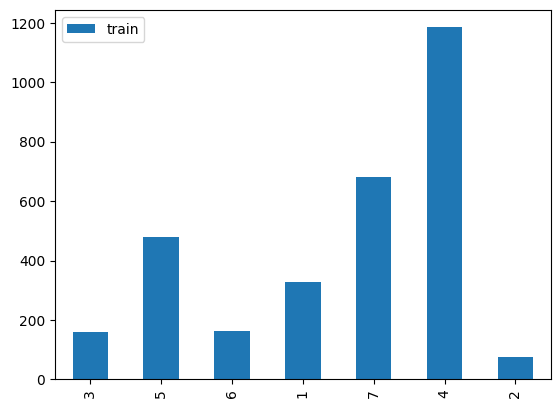

In [ ]:
train_count.transpose().plot(kind='bar')

<Axes: >

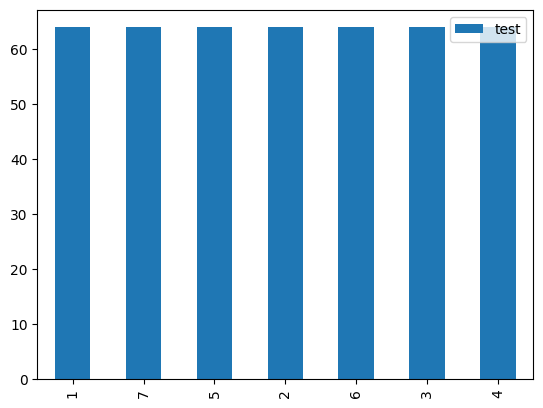

In [ ]:
test_count.transpose().plot(kind='bar')

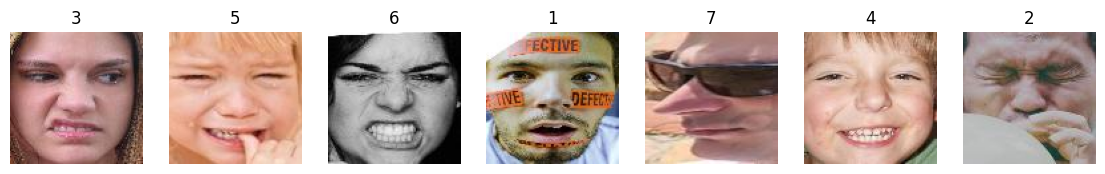

In [ ]:
plt.figure(figsize=(14,22))
i = 1
for expression in os.listdir(train_dir):
    img = load_img((train_dir + expression +'/'+ os.listdir(train_dir + expression)[1]))
    plt.subplot(1,7,i)
    plt.imshow(img)
    plt.title(expression)
    plt.axis('off')
    i += 1
plt.show()

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   zoom_range=0.3,
                                   horizontal_flip=True,
                                   preprocessing_function=tf.keras.applications.vgg16.preprocess_input)

test_datagen = ImageDataGenerator(rescale=1./255,
                                        preprocessing_function=tf.keras.applications.vgg16.preprocess_input)

training_set = train_datagen.flow_from_directory(train_dir,
                                                 target_size=(100, 100),
                                                 batch_size=64,
                                                 class_mode='categorical')

test_set = test_datagen.flow_from_directory(test_dir,
                                                        target_size=(100, 100),
                                                        batch_size=64,
                                                        class_mode='categorical')


Found 3068 images belonging to 7 classes.
Found 448 images belonging to 7 classes.


In [ ]:
training_set.class_indices

{'1': 0, '2': 1, '3': 2, '4': 3, '5': 4, '6': 5, '7': 6}

In [ ]:
class TransformerBlock(Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential(
            [Dense(ff_dim, activation="relu"), Dense(embed_dim)]
        )
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

def get_model(input_size, classes=7, num_heads=4, ff_dim=512):
    # Load the VGG16 model pre-trained on ImageNet and exclude the top fully connected layers
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_size)

    # Freeze the layers of the base model
    for layer in base_model.layers:
        layer.trainable = False

    # Extract features
    x = base_model.output
    x = Flatten()(x)

    # Reshape for the transformer
    x = Dense(512, activation='relu')(x)
    x = tf.reshape(x, (-1, 1, 512))  # Reshape to (batch_size, sequence_length, embedding_dim)

    # Transformer block
    transformer_block = TransformerBlock(embed_dim=512, num_heads=num_heads, ff_dim=ff_dim)
    x = transformer_block(x)

    # Additional attention layer
    additional_attention = MultiHeadAttention(num_heads=num_heads, key_dim=512)
    x = additional_attention(x, x)

    # Global average pooling
    x = GlobalAveragePooling1D()(x)

    # Fully connected layers
    x = Dense(4096, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(4096, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(classes, activation='softmax')(x)

    # Create the final model
    model = Model(inputs=base_model.input, outputs=predictions)

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model



In [ ]:
row, col = 100, 100
classes = 7
input_size = (row, col, 3)

fernet = get_model((row,col,3), classes)
fernet.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 100, 100, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 100, 100, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 block1_conv2 (Conv2D)       (None, 100, 100, 64)         36928     ['block1_conv1[0][0]']        
                                                                                                  
 block1_pool (MaxPooling2D)  (None, 50, 50, 64)           0         ['block1_conv2[0][0]']        
                             

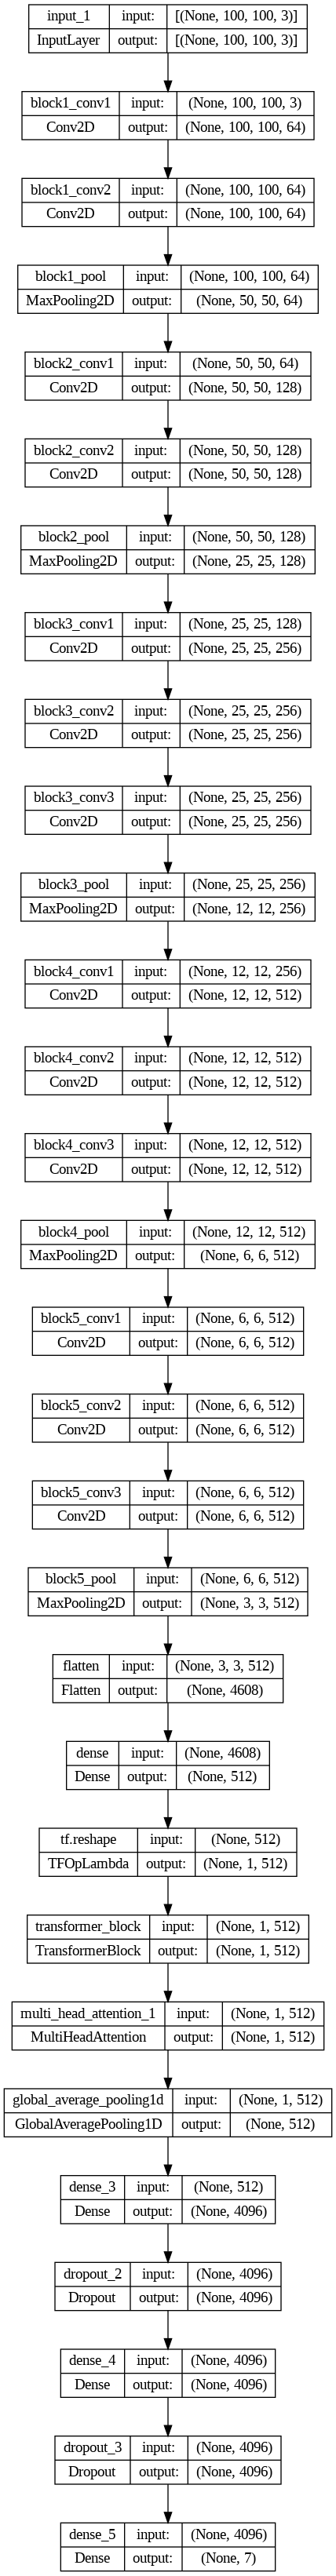

In [ ]:
plot_model(fernet, to_file='fernet.png', show_shapes=True, show_layer_names=True)

In [ ]:
chk_path = 'ferNet.h5'
log_dir = "checkpoint/logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

checkpoint = ModelCheckpoint(filepath=chk_path,
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             moniter='val_loss')

earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=3,
                          verbose=1,
                          restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=6,
                              verbose=1,
                              min_delta=0.0001)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
csv_logger = CSVLogger('training.log')

callbacks = [checkpoint, reduce_lr, csv_logger]



In [ ]:
steps_per_epoch = training_set.n // training_set.batch_size
validation_steps = test_set.n // test_set.batch_size

hist = fernet.fit(x=training_set,
                 validation_data=test_set,
                 epochs=50,
                 callbacks=callbacks,
                 steps_per_epoch=steps_per_epoch,
                 validation_steps=validation_steps)

Epoch 1/50
47/47 [==============================] - ETA: 0s - loss: 1.6109 - accuracy: 0.3898 
Epoch 1: val_loss improved from inf to 2.02863, saving model to ferNet.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


47/47 [==============================] - 910s 19s/step - loss: 1.6109 - accuracy: 0.3898 - val_loss: 2.0286 - val_accuracy: 0.2500 - lr: 1.0000e-04
Epoch 2/50
47/47 [==============================] - ETA: 0s - loss: 1.3653 - accuracy: 0.5057
Epoch 2: val_loss improved from 2.02863 to 1.76594, saving model to ferNet.h5
47/47 [==============================] - 22s 457ms/step - loss: 1.3653 - accuracy: 0.5057 - val_loss: 1.7659 - val_accuracy: 0.3326 - lr: 1.0000e-04
Epoch 3/50
47/47 [==============================] - ETA: 0s - loss: 1.2493 - accuracy: 0.5429
Epoch 3: val_loss improved from 1.76594 to 1.61493, saving model to ferNet.h5
47/47 [==============================] - 21s 444ms/step - loss: 1.2493 - accuracy: 0.5429 - val_loss: 1.6149 - val_accuracy: 0.3973 - lr: 1.0000e-04
Epoch 4/50
47/47 [==============================] - ETA: 0s - loss: 1.1668 - accuracy: 0.5846
Epoch 4: val_loss improved from 1.61493 to 1.43300, saving model to ferNet.h5
47/47 [==============================]

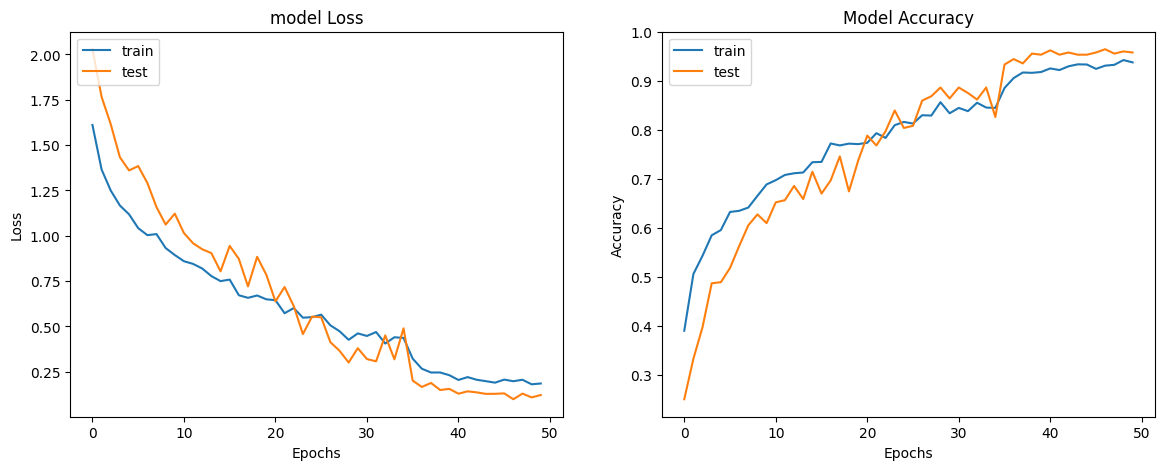

In [ ]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,2)
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'], loc='upper left')

plt.subplot(1,2,1)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
train_loss, train_accu = fernet.evaluate(training_set)
test_loss, test_accu = fernet.evaluate(test_set)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_accu*100, test_accu*100))

7/7 [==============================] - 2s 232ms/step - loss: 0.1218 - accuracy: 0.9576
final train accuracy = 94.33 , validation accuracy = 95.76


In [ ]:
fernet.save_weights('fernet_bestweight.h5')

48/48 [==============================] - 18s 363ms/step
Confusion Matrix
[[ 39   6  13 147  51  21  52]
 [  8   2   3  25  12   8  16]
 [ 16   4  11  62  22  10  35]
 [112  34  42 485 200  56 256]
 [ 50  11  26 195  73  28  95]
 [ 16   3   5  63  29   5  41]
 [ 75  15  31 271 119  31 138]]
Classification Report
              precision    recall  f1-score   support

           1       0.12      0.12      0.12       329
           2       0.03      0.03      0.03        74
           3       0.08      0.07      0.08       160
           4       0.39      0.41      0.40      1185
           5       0.14      0.15      0.15       478
           6       0.03      0.03      0.03       162
           7       0.22      0.20      0.21       680

    accuracy                           0.25      3068
   macro avg       0.15      0.14      0.14      3068
weighted avg       0.24      0.25      0.24      3068



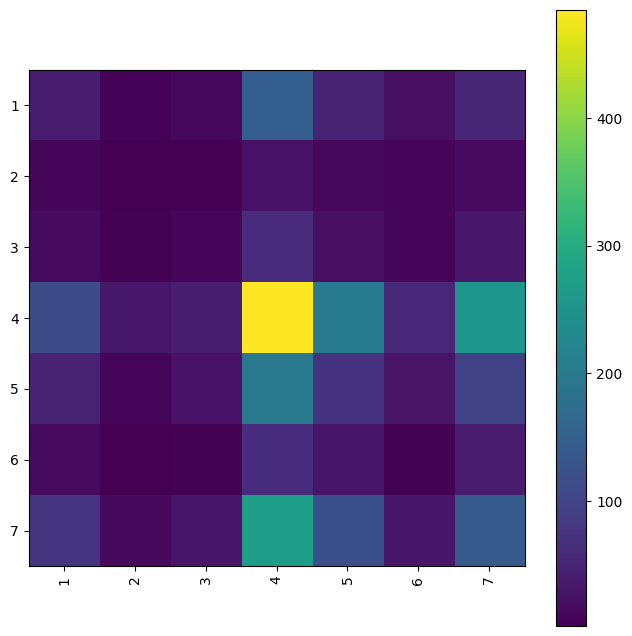

In [ ]:
y_pred = fernet.predict(training_set)
y_pred = np.argmax(y_pred, axis=1)
class_labels = test_set.class_indices
class_labels = {v:k for k,v in class_labels.items()}

from sklearn.metrics import classification_report, confusion_matrix
cm_train = confusion_matrix(training_set.classes, y_pred)
print('Confusion Matrix')
print(cm_train)
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(training_set.classes, y_pred, target_names=target_names))

plt.figure(figsize=(8,8))
plt.imshow(cm_train, interpolation='nearest')
plt.colorbar()
tick_mark = np.arange(len(target_names))
_ = plt.xticks(tick_mark, target_names, rotation=90)
_ = plt.yticks(tick_mark, target_names)

7/7 [==============================] - 2s 219ms/step
Confusion Matrix
[[17  9  3  9  8  8 10]
 [ 7  8 10 10 10  6 13]
 [ 6 12  8  8 12 10  8]
 [ 4  9 13  9 12  7 10]
 [11 10  5  8  9 13  8]
 [ 6  7 10 13  8 11  9]
 [ 9  8  8 13 11  8  7]]
Classification Report
              precision    recall  f1-score   support

           1       0.28      0.27      0.27        64
           2       0.13      0.12      0.13        64
           3       0.14      0.12      0.13        64
           4       0.13      0.14      0.13        64
           5       0.13      0.14      0.13        64
           6       0.17      0.17      0.17        64
           7       0.11      0.11      0.11        64

    accuracy                           0.15       448
   macro avg       0.16      0.15      0.15       448
weighted avg       0.16      0.15      0.15       448



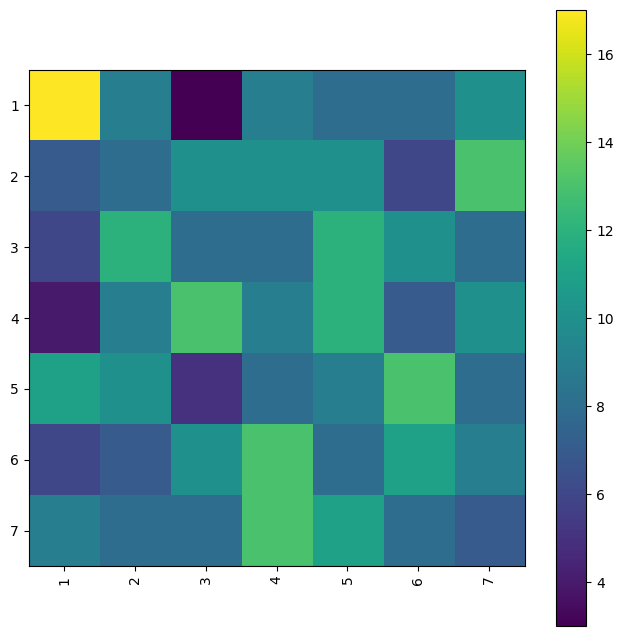

In [ ]:
y_pred = fernet.predict(test_set)
y_pred = np.argmax(y_pred, axis=1)
class_labels = test_set.class_indices
class_labels = {v:k for k,v in class_labels.items()}

#from sklearn.metrics import classification_report, confusion_matrix
cm_test = confusion_matrix(test_set.classes, y_pred)
print('Confusion Matrix')
print(cm_test)
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(test_set.classes, y_pred, target_names=target_names))

plt.figure(figsize=(8,8))
plt.imshow(cm_test, interpolation='nearest')
plt.colorbar()
tick_mark = np.arange(len(target_names))
_ = plt.xticks(tick_mark, target_names, rotation=90)
_ = plt.yticks(tick_mark, target_names)